In [1]:
%run ./SimPreliminaries.ipynb

### How to Run a Simulation

Arguments to run simulation:
* **G, pairs:** Graph and a list of pairings. These are both output by calling gen_network. 
* **network_type:** either `'S'` (spatially embedded) or `'H'` (homogeneously mixing) depending on what the network type is. 
* **possible_choices:** refers to which prior is being used. Either `htprior` or `faceprior` depending on which experimental prior desired
* **num_rounds:** number of rounds we want to run. Usually 40 for comparison to the experimental runs.
* **alpha***: network-level learning parameter; numerical parameter for the background probability calculation can be any number ≥ 0.
* **gamma***: network-level self-valuation parameter; value in [0, 1] that indicates preference for repeating self over repeating partner.
* **response_type:** either `'Hashtag'` or `'Face'` depending on which prior is being used. This is only included so the output dataframes match the experimentally outputted dataframes. 

\* CAA simulation only

Steps:
1. Call **`gen_network(n, network_type, num_rounds)`** where `n` is the number of nodes, `network_type` is a string indicating either `'spatially_embedded'` or `'homogeneously_mixing'` and `num_rounds` is the number of desired simulation rounds (usually 40). 
2. Depending on which simulation you want to run, call either\
    a. **`centola_simulation(G, pairs, network_type, possible_choices, num_rounds, response_type)`** or\
    b. **`caa_simulation(G, pairs, network_type, possible_choices, num_rounds, alpha, gamma, response_type)`** \
    where each of the parameters are as defined above and the value for `num_rounds` is the same as the ones passed in to **`gen_network`**.

In [2]:
def centola_simulation(G, pairs, network_type, possible_choices, num_rounds, response_type):
    '''
    This function will run the utility simulation.
    
    PARAMETERS:
    -----------
    G: networkx graph; created using gen_network function, the graph has all the properties of the network we want to run the simulation on.
    pairs: pairings of nodes for each timestep of the simulation, also generated by gen_network function.
    network_type: string; indicates if the graph is homogeneously_mixing (H) or Spatially Embedded (S)
    possible_choices: this refers to the prior we want to use (either htprior or faceprior) which are generated from live experiment runs.
    num_rounds: the number of rounds we want to run the simulation for (usually 40 for comparison to actual trial runs).
    response_type: string; this indicates either 'hashtag' or 'name' based on the prior being used. This ensures that dataframe formatting doesn't get messed up.
    
    RETURNS:
    --------
    G: networkx graph; the updated graph (node attributes like score, choice) are updated during the simulation so this allows us access to those updates.
    df: Pandas dataframe; contains all information about the simulation run (ie response of each agent at each trial, decision type, etc.)
        if store == True, this dataframe will be saved to the relevant folder.
    '''
    
    possible_choices = list(set(possible_choices))
    n = G.order() # number of nodes in the network
    choices = {i + 1: random.choice(possible_choices) for i in range(n)} # generates initial choices for each node, which are numbered starting at 1, not 0
    nx.set_node_attributes(G, choices, 'choice') # sets the node attributes in the network to be the generated choices
    choices_t = choices # choices_t variable will store the choices for each individual at the current timestep as a dictionary
    
    memory_per_node = {i: [] for i in range(1, n+1)} # keeps track of individual priors, will be updated as context grows
    #responses_seen = {i: [] for i in range(1, n+1)} # the responses each node is exposed to to keep track of EC
    
    # data dictionary which keeps track of the information desired in the return dataframe. This will be updated during each timestep of the simulation.
    data = {'id': [], # id is the label on the node
            'ResponseType': [], #response type is passed as an arg to the function, indicates name or hashtag
            'TrialNumber': [], # this is just to initialize the data frame to include randomly generated initial choices, for round 0
            'Response': [], # original choices for each node
            'Group': [], # group variable is used to denote pairings at each timestep. If two nodes have the same group number at the same timestep, they were paired.
            'Points': [], # this will indicate whether the specific node scored a point during a specific timestep (ie matched with their partner)
            'DecisionType': []} # This will be filled in with 'BN', 'EC', 'RS', or 'RP' based on node decision type. 
    
    current_decision = {i: 'BN' for i in range(1, n+1)} # we will use this to access decision types that lead to scores
    score = {i: 0 for i in range(1, n+1)} # their total score

    curr_t = 1 # current timestep is 1. 
    for T in range(1, num_rounds+1): # each round (Trial) of the simulation
        
        data['Response'] += list(nx.get_node_attributes(G, 'choice').values()) # gives what each node 'locked in'
        data['DecisionType'] += current_decision.values() # gives the decision type they made
        
        curr_pairs = pairs[T-1] # length of pairs is the total number of rounds, so the pairs for the current round are in position T-1
                                # (because T starts at 1)
        curr_group = 0 # sets the value of the current group to 0. This will be incremented for each individual pair to have different values for each pairing.
        group = [-1] * n # creates a list to store group data that is the appropriate length for the trial.
        pts = [0] *n # creates a list to store point scoring data that is the appropriate length for the trial.
        choices_u = copy.deepcopy(choices_t) # creates copy that does not alter choices_t, updated with choices for the next timestep
        
        for pair in curr_pairs: # loop through each pairing.
            # if their choices match, they score a point.
            p1, p2 = pair[0], pair[1]
            group[p1-1] = curr_group # set the appropriate indices in the group list to the current group value so that the two paired nodes have the same val in the group list.
            group[p2-1] = curr_group
            p1choice = choices_t[p1] # player 1's current choice
            p2choice = choices_t[p2] # player 2's current choice
            
            ## assign one person to be the speaker and one person to be the hearer
            speaker_or_hearer = random.random()
            
            if speaker_or_hearer < 0.5:
                speaker = 1
                hearer = 2
                # player 1 will be the speaker
                if p1choice in memory_per_node[p2]:
                    # if p2 has this response in their prior
                    score[p1] += 1
                    score[p2] += 1
                    pts[p1-1] = 1
                    pts[p2-1] = 1
                    
                    memory_per_node[p1] = [p1choice]
                    memory_per_node[p2] = [p1choice]
                
                else:
                    memory_per_node[p2] += [p1choice]
            
            else:
                speaker = 2
                hearer = 1
                # player 2 is the speaker
                
                if p2choice in memory_per_node[p1]:
                    score[p1] += 1
                    score[p2] += 1
                    pts[p1-1] = 1
                    pts[p2-1] = 1
                    
                    memory_per_node[p1] = [p2choice]
                    memory_per_node[p2] = [p2choice]
                
                else:
                    memory_per_node[p1] += [p2choice]
            
            #############################################################
            ## WE ARE NOW GENERATING THEIR CHOICES FOR THE NEXT TRIAL. ##
            #############################################################
            
            # 1. PLAYER 1
            
            if len(memory_per_node[p1]) > 0:
                choices_u[p1] = random.choice(memory_per_node[p1])
                
                if hearer == 1 and choices_u[p1] == p2choice: # it is only possible to repeat your partner if you are the hearer, because otherwise you dont know what your partner's response was
                    
                    if choices_u[p1] == p1choice:
                        rs = random.random()
                        if rs <0.5:
                            current_decision[p1] = 'RS'
                        else:
                            current_decision[p1] = 'RP'
                    else:
                        current_decision[p1] = 'RP'
                
                elif choices_u[p1] == p1choice:
                    current_decision[p1] = 'RS'
                else:
                    current_decision[p1] = 'EC'
                    
            else:
                choices_u[p1] = random.choice(list(set(possible_choices)))
                current_decision[p1] = 'BN'
                
            # 2. PLAYER 2
            if len(memory_per_node[p2]) > 0:
                choices_u[p2] = random.choice(memory_per_node[p2])
                
                if hearer == 2 and choices_u[p2] == p1choice:
                    if choices_u[p2] == p2choice:
                        rs = random.random()
                        if rs < 0.5:
                            current_decision[p2] = 'RS'
                        else:
                            current_decision[p2] = 'RP'
                    else:
                        current_decision[p2] = 'RP'
                    
                elif choices_u[p2] == p2choice:
                    current_decision[p2] = 'RS'
                else:
                    current_decision[p2] = 'EC'
                    
            else:
                choices_u[p2] = random.choice(list(set(possible_choices)))
                current_decision[p2] = 'BN'
                
            curr_group += 1
        
        choices_t = copy.deepcopy(choices_u) # now set choices for the 'current' timestep to be the selections made.
        
        nx.set_node_attributes(G, score, 'score') # update score node attributes appropriately
        nx.set_node_attributes(G, choices_t, 'choice') # update choice node attributes appropriately

        # add new info to data dictionary
        data['id'] += list(range(1, n+1)) # node id numbers
        data['ResponseType'] += [response_type] * n # same response type for all n nodes
        data['TrialNumber'] += [curr_t] *n # current trial number
        data['Group'] += group # adds group information
        data['Points'] += pts # updates whether or not each node scored a point
        
        curr_t += 1 # increments the current t val
    
    df = pd.DataFrame(data) # creates a dataframe of the final info after all trials have been run

    return G, df # return updated graph and the dataframe of all of the information.

In [3]:
def prob_background(alpha, T, C): # weight
    '''alpha is the user defined learning parameter
    T: current simulation timestep
    C: number of points gained by sampling from context (RS or RP)'''
    prob_background = alpha/ (T + alpha + C)
    return prob_background

In [4]:
## THIS IS IMPORTANT, ALLOWS FOR ALL DECISION TYPES (previously some options were excluded)
def binary_decision(rp_points, context_points, gamma):
    '''
    Generates the probability of switching to partner choice based on percieved utility of RP.
    
    rp_points: integer; total points scored by individual using rp strategy.
    context_points: integer; total points scored by individual using context. 
    
    gamma: float in (0, 1]; allows adjustment of the probability of RP.
    '''
    # if context_points == 0:
    #     prob_rp = 0.5
    
    prob_rp = gamma*((rp_points+ 1)/(context_points + 2))
    
    return prob_rp

exp = lambda x, lmbda: lmbda * np.e **(-lmbda * x)

In [5]:
def CAA_simulation(G, pairs, network_type, possible_choices, num_rounds, alphas, gammas, response_type):
    '''
    This function will run the utility simulation.
    
    PARAMETERS:
    -----------
    G: networkx graph; created using gen_network function, the graph has all the properties of the network we want to run the simulation on.
    pairs: pairings of nodes for each timestep of the simulation, also generated by gen_network function.
    network_type: string; indicates if the graph is homogeneously_mixing (H) or Spatially Embedded (S)
    possible_choices: this refers to the prior we want to use (either htprior or faceprior) which are generated from live experiment runs.
    num_rounds: the number of rounds we want to run the simulation for (usually 40 for comparison to actual trial runs).
    alpha: 
    weight: integer; user defined parameter that indicates how much weight to put on seen partner responses when updating agents' individual priors.
    response_type: string; this indicates either 'hashtag' or 'name' based on the prior being used. This ensures that dataframe formatting doesn't get messed up.
    
    RETURNS:
    --------
    G: networkx graph; the updated graph (node attributes like score, choice) are updated during the simulation so this allows us access to those updates.
    df: Pandas dataframe; contains all information about the simulation run (ie response of each agent at each trial, decision type, etc.)
        if store == True, this dataframe will be saved to the relevant folder.
    '''

    n = G.order() # number of nodes in the network
    choices = {i + 1: random.choice(possible_choices) for i in range(n)} # generates initial choices for each node, which are numbered starting at 1, not 0
    nx.set_node_attributes(G, choices, 'choice') # sets the node attributes in the network to be the generated choices
    choices_t = choices # choices_t variable will store the choices for each individual at the current timestep as a dictionary
    
    ec_per_node = {i: [] for i in range(1, n+1)} # keeps track of individual priors, will be updated as context grows
    
    # data dictionary which keeps track of the information desired in the return dataframe. This will be updated during each timestep of the simulation.
    data = {'id': [], # id is the label on the node
            'ResponseType': [], #response type is passed as an arg to the function, indicates name or hashtag
            'TrialNumber': [], # this is just to initialize the data frame to include randomly generated initial choices, for round 0
            'Response': [], # original choices for each node
            'Group': [], # group variable is used to denote pairings at each timestep. If two nodes have the same group number at the same timestep, they were paired.
            'Points': [], # this will indicate whether the specific node scored a point during a specific timestep (ie matched with their partner)
            'DecisionType': []} # This will be filled in with 'BN', 'EC', 'RS', or 'RP' based on node decision type. 
    
    current_decision = {i: 'BN' for i in range(1, n+1)} # we will use this to access decision types that lead to scores
    
    #### The following dictionaries keep track of data necessary to calculate the binary decision probabilities for a node
    rp_pts = {i: 0 for i in range(1, n+1)} # number of times they switched to partner response and got a point                                      
    ec_pts = {i: 0 for i in range(1, n+1)} # number of times each node drew from earlier context and got a point
    rs_pts = {i: 0 for i in range(1, n+1)} # number of times each node kept their choice and got a point
    score = {i: 0 for i in range(1, n+1)} # their total score
    
    curr_t = 1 # current timestep is 1. 
    for T in range(1, num_rounds+1): # each round (Trial) of the simulation
        
        data['Response'] += list(nx.get_node_attributes(G, 'choice').values()) # gives what each node 'locked in'
        data['DecisionType'] += current_decision.values() # gives the decision type they made
        
        curr_pairs = pairs[T-1] # length of pairs is the total number of rounds, so the pairs for the current round are in position T-1
                                # (because T starts at 1)
        curr_group = 0 # sets the value of the current group to 0. This will be incremented for each individual pair to have different values for each pairing.
        group = [-1] * n # creates a list to store group data that is the appropriate length for the trial.
        pts = [0] *n # creates a list to store point scoring data that is the appropriate length for the trial.
        choices_u = copy.deepcopy(choices_t) # creates copy that does not alter choices_t, updated with choices for the next timestep
        
        for pair in curr_pairs: # loop through each pairing.
            # if their choices match, they score a point.
            p1, p2 = pair[0], pair[1]
            group[p1-1] = curr_group # set the appropriate indices in the group list to the current group value so that the two paired nodes have the same val in the group list.
            group[p2-1] = curr_group
            p1choice = choices_t[p1] # player 1's current choice
            p2choice = choices_t[p2] # player 2's current choice
            
            if p1choice==p2choice: # they match! they each score a point for the current trial.
                score[p1] += 1
                score[p2] += 1
                pts[p1-1] = 1
                pts[p2-1] = 1
                
                # checks what type of decision led to this point in order to update the proper dictionaries.
                # weight number of points by T to encourage recent decisions that scored points.
                if current_decision[p1] == 'RP':
                    rp_pts[p1] += T
                if current_decision[p2] == 'RP':
                    rp_pts[p2] += T
                    
                if current_decision[p1] == 'EC':
                    ec_pts[p1] += T
                if current_decision[p2] == 'EC':
                    ec_pts[p2] += T
                
                if current_decision[p1] == 'RS':
                    rs_pts[p1] += T
                if current_decision[p2] == 'RS':
                    rs_pts[p2] += T

            #############################################################
            ## WE ARE NOW GENERATING THEIR CHOICES FOR THE NEXT TRIAL. ##
            #############################################################
            
            # 1. PLAYER 1
            ### a. P(BN)
            p1_c = ec_pts[p1] + rp_pts[p1] + rs_pts[p1] # total number of points scored when drawing from context
            p1_background = prob_background(alphas[p1-1], T, p1_c)
            
            rand1 = random.random() # generate random numbers so that we can make the decisions according to the probabilities.
            
            ### PLAYER 1 DECISION
            if rand1 < p1_background: # P1 SAMPLE FROM BACKGROUND (BN)
                choices_u[p1] = random.choice(possible_choices) # sampling from p1 original prior
                current_decision[p1] = 'BN'
            
            else: # P1 SAMPLE FROM CONTEXT
                ec_or_not_p1 = random.random()
                rand_switch1 = random.random()
                
                # b. P(EC)
                    
                prob_ec = (ec_pts[p1]+ 3 )/(ec_pts[p1] + rp_pts[p1] + rs_pts[p1] + 20) # this makes sure no decision strategies are impossible
                
                if ec_or_not_p1 < prob_ec and len(ec_per_node[p1]) > 0 and T > 1:
                    choices_u[p1] = random.choice(ec_per_node[p1])
                    current_decision[p1] = 'EC'
                
                else: # c. P(RP) and P(RS)
                    binary_pts_p1 = rp_pts[p1] + rs_pts[p1] # RS/RP points
                    p1_rp = binary_decision(rp_pts[p1], binary_pts_p1, gammas[p1-1])
                
                    if rand_switch1 < p1_rp: # player 1 repeats player 2's choice
                        choices_u[p1] = p2choice
                        current_decision[p1] = 'RP'
                    else: # player 1 keeps current choice
                        choices_u[p1] = p1choice
                        current_decision[p1] = 'RS'
            
            ### 2. PLAYER 2
            ### a. P(BN)
            p2_c = ec_pts[p2] + rp_pts[p2] + rs_pts[p2]
            p2_background = prob_background(alphas[p2-1], T, p2_c)
            
            rand2 = random.random()
            
            if rand2 < p2_background: # P2 SAMPLE FROM BACKGROUND (PRIOR)
                choices_u[p2] = random.choice(possible_choices)
                current_decision[p2] = 'BN'
            
            else: # P2 SAMPLE FROM CONTEXT
                ec_or_not_p2 = random.random()
                rand_switch2 = random.random()
                
                # b. P(EC)
                prob_ec = (ec_pts[p2]+3)/(ec_pts[p2] + rs_pts[p2] + rp_pts[p2] + 20)
                
                if ec_or_not_p2 < prob_ec and len(ec_per_node[p2]) > 0 and T > 1:
                    choices_u[p2] = random.choice(ec_per_node[p2])
                    current_decision[p1] = 'EC'
                        
                else: # c. P(RS) and P(RP)
                    binary_pts_p2 = rp_pts[p2] + rs_pts[p2]
                    p2_rp = binary_decision(rp_pts[p2], binary_pts_p2, gammas[p2-1])
                
                    if rand_switch2 < p2_rp:
                        choices_u[p2] = p1choice
                        current_decision[p2] = 'RP'
                    
                    else:
                        choices_u[p2] = p2choice
                        current_decision[p2] = 'RS'
                        
            if p1choice == p2choice: # if they match already, add two times as many instances to each prior so it is more likely for them to repeat themselves
                ec_per_node[p1] += [p2choice] * (T*50)
                ec_per_node[p2] += [p1choice] * (T*50)
            
            else:
                ec_per_node[p1] += [p2choice] * (T)
                ec_per_node[p2] += [p1choice] * (T)
                
            curr_group += 1
        
        choices_t = copy.deepcopy(choices_u) # now set choices for the 'current' timestep to be the selections made.
        
        nx.set_node_attributes(G, score, 'score') # update score node attributes appropriately
        nx.set_node_attributes(G, choices_t, 'choice') # update choice node attributes appropriately

        # add new info to data dictionary
        data['id'] += list(range(1, n+1)) # node id numbers
        data['ResponseType'] += [response_type] * n # same response type for all n nodes
        data['TrialNumber'] += [curr_t] *n # current trial number
        data['Group'] += group # adds group information
        data['Points'] += pts # updates whether or not each node scored a point
        
        curr_t += 1 # increments the current t val
    
    df = pd.DataFrame(data) # creates a dataframe of the final info after all trials have been run

    return G, df # return updated graph and the dataframe of all of the information.

In [6]:
# alpha, gamma = 4.9, 1
# n_vals = [(20, normalize20), (50, normalize50)]
# rounds = 40
# trials = 100

# network_type = 'homogeneously_mixing'
# prior = htprior
# response_type = 'HT'

# hh_caa_dfs = {'20':[], '50':[]}
# hh_centola_dfs = {'20':[], '50':[]}

# for tup in n_vals:
#     n = tup[0]
#     G, pairs = gen_network(n, network_type, rounds)
#     for t in range(trials):
        
#         caaG, caaDF = CAA_simulation(G, pairs, 'S', prior, rounds, alpha, gamma, response_type)
#         baselineG, baselineDF = centola_simulation(G, pairs, 'S', prior, rounds, response_type)
#         if n == 20:
#             hh_caa_dfs['20'].append(caaDF)
#             hh_centola_dfs['20'].append(baselineDF)
#         else:
#             hh_caa_dfs['50'].append(caaDF)
#             hh_centola_dfs['50'].append(baselineDF)

In [7]:
data = (np.random.normal(0.9, 0.5, 20))

In [8]:
%run ././ComputedVals.ipynb

In [9]:
alpha, gamma = 0.4, 1
n_vals = [(20, normalize20), (50, normalize50)]
rounds = 40
trials = 100

network_type = 'homogeneously_mixing'
prior = faceprior
response_type = 'Face'

hf_caa_dfs = {'20':[], '50':[]}
hf_centola_dfs = {'20':[], '50':[]}

for tup in n_vals:
    n = tup[0]
    G, pairs = gen_network(n, network_type, rounds)
    for t in range(trials):
        alphas = np.abs(np.random.normal(alpha, alpha/2, n))
        gammas = [1]*n
        
        caaG, caaDF = CAA_simulation(G, pairs, 'H', prior, rounds, alphas, gammas, response_type)
        baselineG, baselineDF = centola_simulation(G, pairs, 'H', prior, rounds, response_type)
        if n == 20:
            hf_caa_dfs['20'].append(caaDF)
            hf_centola_dfs['20'].append(baselineDF)
        else:
            hf_caa_dfs['50'].append(caaDF)
            hf_centola_dfs['50'].append(baselineDF)

In [10]:
alpha, gamma = 0.4, 1
n_vals = [(20, normalize20), (50, normalize50)]
rounds = 40
trials = 100

network_type = 'spatially_embedded'
prior = faceprior
response_type = 'Face'

sf_caa_dfs = {'20':[], '50':[]}
sf_centola_dfs = {'20':[], '50':[]}

for tup in n_vals:
    n = tup[0]
    G, pairs = gen_network(n, network_type, rounds)
    for t in range(trials):
        alphas = np.abs(np.random.normal(alpha, alpha/2, n))
        gammas = [1]*n
        
        caaG, caaDF = CAA_simulation(G, pairs, 'H', prior, rounds, alphas, gammas, response_type)
        baselineG, baselineDF = centola_simulation(G, pairs, 'H', prior, rounds, response_type)
        if n == 20:
            sf_caa_dfs['20'].append(caaDF)
            sf_centola_dfs['20'].append(baselineDF)
        else:
            sf_caa_dfs['50'].append(caaDF)
            sf_centola_dfs['50'].append(baselineDF)

In [11]:
alpha, gamma = 4.9, 1
n_vals = [(20, normalize20), (50, normalize50)]
rounds = 40
trials = 100

network_type = 'spatially_embedded'
prior = htprior
response_type = 'HT'

sh_caa_dfs = {'20':[], '50':[]}
sh_centola_dfs = {'20':[], '50':[]}

for tup in n_vals:
    n = tup[0]
    G, pairs = gen_network(n, network_type, rounds)
    for t in range(trials):
        alphas = np.abs(np.random.normal(alpha, alpha/2, n))
        gammas = [1]*n
        
        caaG, caaDF = CAA_simulation(G, pairs, 'S', prior, rounds, alphas, gammas, response_type)
        baselineG, baselineDF = centola_simulation(G, pairs, 'S', prior, rounds, response_type)
        if n == 20:
            sh_caa_dfs['20'].append(caaDF)
            sh_centola_dfs['20'].append(baselineDF)
        else:
            sh_caa_dfs['50'].append(caaDF)
            sh_centola_dfs['50'].append(baselineDF)

In [12]:
alpha, gamma = 4.9, 1
n_vals = [(20, normalize20), (50, normalize50)]
rounds = 40
trials = 100

network_type = 'homogeneously_mixing'
prior = htprior
response_type = 'HT'

hh_caa_dfs = {'20':[], '50':[]}
hh_centola_dfs = {'20':[], '50':[]}

for tup in n_vals:
    n = tup[0]
    G, pairs = gen_network(n, network_type, rounds)
    for t in range(trials):
        alphas = np.abs(np.random.normal(alpha, alpha/2, n))
        gammas = [1]*n
        
        caaG, caaDF = CAA_simulation(G, pairs, 'S', prior, rounds, alphas, gammas, response_type)
        baselineG, baselineDF = centola_simulation(G, pairs, 'S', prior, rounds, response_type)
        if n == 20:
            hh_caa_dfs['20'].append(caaDF)
            hh_centola_dfs['20'].append(baselineDF)
        else:
            hh_caa_dfs['50'].append(caaDF)
            hh_centola_dfs['50'].append(baselineDF)

In [13]:
## Gotta compute normalized avg entropies for the experiments and I have the ones for the control
#normalized_avg_entropies=[hf_avg_normalized, sf_avg_normalized, hh_avg_normalized, sh_avg_normalized]

hf_exp_avg_entropy = hf_avg_normalized
sf_exp_avg_entropy = sf_avg_normalized
hh_exp_avg_entropy = hh_avg_normalized
sh_exp_avg_entropy = sh_avg_normalized

In [14]:
hf_caa_entropies = []
for df in hf_caa_dfs['20']:
    ent = np.array(compute_entropy(df))
    normalized = ent/normalize20
    hf_caa_entropies.append(normalized)
    
for df in hf_caa_dfs['50']:
    ent = np.array(compute_entropy(df))
    normalized = ent/normalize50
    hf_caa_entropies.append(normalized)

hf_caa_avg_entropy = np.mean(hf_caa_entropies, axis=0)

In [15]:
hf_control_entropies = []
for df in hf_centola_dfs['20']:
    ent = np.array(compute_entropy(df))
    normalized = ent/normalize20
    hf_control_entropies.append(normalized)
    
for df in hf_centola_dfs['50']:
    ent = np.array(compute_entropy(df))
    normalized = ent/normalize50
    hf_control_entropies.append(normalized)

hf_control_avg_entropy = np.mean(hf_control_entropies, axis=0)

In [16]:
sf_caa_entropies = []
for df in sf_caa_dfs['20']:
    ent = np.array(compute_entropy(df))
    normalized = ent/normalize20
    sf_caa_entropies.append(normalized)
    
for df in sf_caa_dfs['50']:
    ent = np.array(compute_entropy(df))
    normalized = ent/normalize50
    sf_caa_entropies.append(normalized)

sf_caa_avg_entropy = np.mean(sf_caa_entropies, axis=0)

In [17]:
sf_control_entropies = []
for df in sf_centola_dfs['20']:
    ent = np.array(compute_entropy(df))
    normalized = ent/normalize20
    sf_control_entropies.append(normalized)
    
for df in sf_centola_dfs['50']:
    ent = np.array(compute_entropy(df))
    normalized = ent/normalize50
    sf_control_entropies.append(normalized)

sf_control_avg_entropy = np.mean(sf_control_entropies, axis=0)

In [18]:
hh_caa_entropies = []
for df in hh_caa_dfs['20']:
    ent = np.array(compute_entropy(df))
    normalized = ent/normalize20
    hh_caa_entropies.append(normalized)
    
for df in hh_caa_dfs['50']:
    ent = np.array(compute_entropy(df))
    normalized = ent/normalize50
    hh_caa_entropies.append(normalized)

hh_caa_avg_entropy = np.mean(hh_caa_entropies, axis=0)

In [19]:
hh_control_entropies = []
for df in hh_centola_dfs['20']:
    ent = np.array(compute_entropy(df))
    normalized = ent/normalize20
    hh_control_entropies.append(normalized)
    
for df in hh_centola_dfs['50']:
    ent = np.array(compute_entropy(df))
    normalized = ent/normalize50
    hh_control_entropies.append(normalized)

hh_control_avg_entropy = np.mean(hh_control_entropies, axis=0)

In [20]:
sh_caa_entropies = []
for df in sh_caa_dfs['20']:
    ent = np.array(compute_entropy(df))
    normalized = ent/normalize20
    sh_caa_entropies.append(normalized)
    
for df in sh_caa_dfs['50']:
    ent = np.array(compute_entropy(df))
    normalized = ent/normalize50
    sh_caa_entropies.append(normalized)

sh_caa_avg_entropy = np.mean(sh_caa_entropies, axis=0)

In [21]:
sh_control_entropies = []
for df in sh_centola_dfs['20']:
    ent = np.array(compute_entropy(df))
    normalized = ent/normalize20
    sh_control_entropies.append(normalized)
    
for df in sh_centola_dfs['50']:
    ent = np.array(compute_entropy(df))
    normalized = ent/normalize50
    sh_control_entropies.append(normalized)

sh_control_avg_entropy = np.mean(sh_control_entropies, axis=0)

In [51]:
# HH_exp = df['Experimental Homogeneous Hashtag']
# HH_control = df['Centola Homogeneous Hashtag']
# HH_caa = df['CAA Homogeneous Hashtag']

# SH_exp = df['Experimental Spatial Hashtag']
# SH_control = df['Centola Spatial Hashtag']
# SH_caa = df['CAA Spatial Hashtag']

# HF_exp = df['Experimental Homogeneous Face']
# HF_control = df['Centola Homogeneous Face']
# HF_caa = df['CAA Homogeneous Face']

# SF_exp = df['Experimental Spatial Face']
# SF_control = df['Centola Spatial Face']
# SF_caa = df['CAA Spatial Face']

In [22]:
data = {'Trial': list(range(1, 41)),
        'Experimental Homogeneous Hashtag': hh_exp_avg_entropy,
        'Centola Homogeneous Hashtag': hh_control_avg_entropy,
        'CAA Homogeneous Hashtag': hh_caa_avg_entropy,
        'Experimental Spatial Hashtag': sh_exp_avg_entropy,
        'Centola Spatial Hashtag': sh_control_avg_entropy,
        'CAA Spatial Hashtag': sh_caa_avg_entropy,
        'Experimental Homogeneous Face': hf_exp_avg_entropy,
        'Centola Homogeneous Face': hf_control_avg_entropy,
        'CAA Homogeneous Face': hf_caa_avg_entropy,
        'Experimental Spatial Face': sf_exp_avg_entropy,
        'Centola Spatial Face': sf_control_avg_entropy,
        'CAA Spatial Face': sf_caa_avg_entropy}

In [24]:
df = pd.DataFrame(data, index=data['Trial'])
# df.to_csv('Entropy Optimization/EntropyComparisonFig.csv')

In [54]:
#df.to_csv('Entropy Optimization/EntropyComparisonFigPNAS_UPDATE.csv')

In [55]:
#df = pd.read_csv('Entropy Optimization/EntropyComparisonFigPNAS_UPDATE.csv')

In [25]:
df.columns

Index(['Trial', 'Experimental Homogeneous Hashtag',
       'Centola Homogeneous Hashtag', 'CAA Homogeneous Hashtag',
       'Experimental Spatial Hashtag', 'Centola Spatial Hashtag',
       'CAA Spatial Hashtag', 'Experimental Homogeneous Face',
       'Centola Homogeneous Face', 'CAA Homogeneous Face',
       'Experimental Spatial Face', 'Centola Spatial Face',
       'CAA Spatial Face'],
      dtype='object')

In [27]:
HH_exp = df['Experimental Homogeneous Hashtag']
HH_control = df['Centola Homogeneous Hashtag']
HH_caa = df['CAA Homogeneous Hashtag']

SH_exp = df['Experimental Spatial Hashtag']
SH_control = df['Centola Spatial Hashtag']
SH_caa = df['CAA Spatial Hashtag']

HF_exp = df['Experimental Homogeneous Face']
HF_control = df['Centola Homogeneous Face']
HF_caa = df['CAA Homogeneous Face']

SF_exp = df['Experimental Spatial Face']
SF_control = df['Centola Spatial Face']
SF_caa = df['CAA Spatial Face']

In [28]:
import seaborn as sns
pal = sns.color_palette('colorblind')
sns.set_theme(style='darkgrid')

In [29]:
def create_entropy_comparison_models():
    mosaic = [
                ["HT_control", "HT_CAA"],
                ["Face_control", "Face_CAA"],
             ]
    
    fig = plt.figure(figsize=(8, 9))
    axes = fig.subplot_mosaic(mosaic, sharey=True, sharex=True)
    #plt.figure(figsize=(12, 8))
    
    # upper left: hashtag, centola model
    # upper right: hashtag, CAA model
    # lower left: face, centola model
    # lower left: face, CAA model
    exp1 = axes['HT_control'].scatter(range(len(HH_exp)), HH_exp, marker='X', color=pal.as_hex()[0])
    axes['HT_control'].plot(range(len(HH_exp)), HH_exp, color=pal.as_hex()[0])
    
    control1 = axes['HT_control'].scatter(range(len(HH_control)), HH_control, marker='o', color=pal.as_hex()[0])
    axes['HT_control'].plot(range(len(HH_control)), HH_control, color=pal.as_hex()[0])
    
    exp2 = axes['HT_control'].scatter(range(len(SH_exp)), SH_exp, marker='X', color=pal.as_hex()[3])
    axes['HT_control'].plot(range(len(SH_exp)), SH_exp, color=pal.as_hex()[3])
    
    control2 = axes['HT_control'].scatter(range(len(SH_control)), SH_control, marker='o', color=pal.as_hex()[3])
    axes['HT_control'].plot(range(len(SH_control)), SH_control, color=pal.as_hex()[3])
    axes['HT_control'].set_ylabel('Entropy')
    axes['HT_control'].grid('on')
    
    # plt 2
    axes['HT_CAA'].scatter(range(len(HH_exp)), HH_exp, marker='X', color=pal.as_hex()[0])
    axes['HT_CAA'].plot(range(len(HH_exp)), HH_exp, color=pal.as_hex()[0])
    
    caa1 = axes['HT_CAA'].scatter(range(len(HH_caa)), HH_caa, marker='o', color=pal.as_hex()[0])
    axes['HT_CAA'].plot(range(len(HH_caa)), HH_caa, color=pal.as_hex()[0])
    
    axes['HT_CAA'].scatter(range(len(SH_exp)), SH_exp, marker='X', color=pal.as_hex()[3])
    axes['HT_CAA'].plot(range(len(SH_exp)), SH_exp, color=pal.as_hex()[3])
    
    caa2 = axes['HT_CAA'].scatter(range(len(SH_caa)), SH_caa, marker='o', color=pal.as_hex()[3])
    axes['HT_CAA'].plot(range(len(SH_caa)), SH_caa, color=pal.as_hex()[3])
    axes['HT_CAA'].grid('on')
    
    #plt3
    axes['Face_control'].scatter(range(len(HF_exp)), HF_exp, marker='X', color=pal.as_hex()[0])
    axes['Face_control'].plot(range(len(HF_exp)), HF_exp, color=pal.as_hex()[0])
    
    axes['Face_control'].scatter(range(len(HF_control)), HF_control, marker='o', color=pal.as_hex()[0])
    axes['Face_control'].plot(range(len(HF_control)), HF_control, color=pal.as_hex()[0])
    
    axes['Face_control'].scatter(range(len(SF_exp)), SF_exp, marker='X', color=pal.as_hex()[3])
    axes['Face_control'].plot(range(len(SF_exp)), SF_exp, color=pal.as_hex()[3])
    
    axes['Face_control'].scatter(range(len(SF_control)), SF_control, marker='o', color=pal.as_hex()[3])
    axes['Face_control'].plot(range(len(SF_control)), SF_control, color=pal.as_hex()[3])
    axes['Face_control'].set_ylabel('Entropy')
    axes['Face_control'].set_xlabel('Trial Number')
    axes['Face_control'].grid('on')
    
    # plt 4
    axes['Face_CAA'].scatter(range(len(HF_exp)), HF_exp, marker='X', color=pal.as_hex()[0])
    axes['Face_CAA'].plot(range(len(HF_exp)), HF_exp, color=pal.as_hex()[0])
    
    axes['Face_CAA'].scatter(range(len(HF_caa)), HF_caa, marker='o', color=pal.as_hex()[0])
    axes['Face_CAA'].plot(range(len(HF_caa)), HF_caa, color=pal.as_hex()[0])
    
    axes['Face_CAA'].scatter(range(len(SF_exp)), SF_exp, marker='X', color=pal.as_hex()[3])
    axes['Face_CAA'].plot(range(len(SF_exp)), SF_exp, color=pal.as_hex()[3])
    
    axes['Face_CAA'].scatter(range(len(SF_caa)), SF_caa, marker='o', color=pal.as_hex()[3])
    axes['Face_CAA'].plot(range(len(SF_caa)), SF_caa, color=pal.as_hex()[3])
    axes['Face_CAA'].set_xlabel('Trial Number')
    axes['Face_CAA'].grid('on')
    
    
    #plt.suptitle(f'Comparison of Normalized Average Entropies')
    
    handles1 = [(exp1, exp2), (control1, control2)]
    labels1 = ['Experimental Average', 'Model Average']
    handles2 = [(exp1, control1), (exp2, control2)]
    labels2 = ['Homogeneously Mixing', 'Spatially Embedded']
    
    legend1 = fig.legend(handles1, labels1, handler_map={tuple: HandlerTuple(ndivide=None)}, ncol=2, fontsize=8, loc='center', bbox_to_anchor=(0.25, 0))
    legend2 = fig.legend(handles2, labels2, handler_map={tuple: HandlerTuple(ndivide=None)}, ncol=2, fontsize=8, loc='center', bbox_to_anchor=(0.75, 0))
    
    
    fig.add_artist(legend1)
    fig.add_artist(legend2)
    
    
    
    col_headers = ["Control Model", "CAA Model"]
    row_headers = ["Hashtag", "Face"]

    #fig, axes = plt.subplot_mosaic(mosaic, **subplots_kwargs)

    # font_kwargs = dict(fontweight="bold", fontsize="large")
    # add_headers(fig, col_headers=col_headers, row_headers=row_headers, **font_kwargs)

    #plt.show()
    #fig.tight_layout()
    plt.tight_layout()
    plt.savefig('Entropy Optimization/Entropy_ComparisonPNAS_UPDATE.png', bbox_inches='tight')
    #legend(handles, labels, handler_map={tuple: HandlerTuple(ndivide=None)}, ncol=2, loc='outside lower center', fontsize=8)
    
    #plt.show()
    #plt.savefig(save_title, bbox_inches='tight')
    

In [30]:
from matplotlib.legend_handler import HandlerTuple

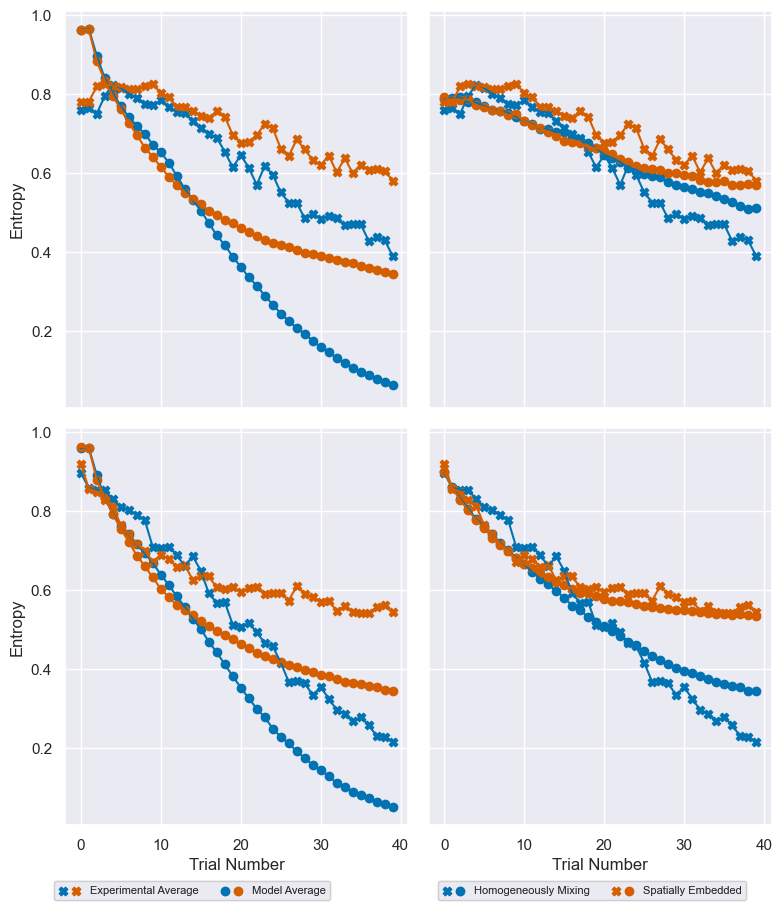

In [31]:
create_entropy_comparison_models()